# Imports

In [1]:
import sys
import os
import torch
import torch_directml
import pandas as pd
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import json
from nltk.tokenize import word_tokenize
import numpy as np
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

/home/kolton/miniconda3/envs/pydml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
def get_bert_embedding(text, tokenizer, model, device, max_length):
    # Tokenize the text
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=max_length).to(device)

    # Get BERT model outputs
    with torch.no_grad():
        outputs = model(**tokens)
        last_hidden_states = outputs.last_hidden_state

        # Average pooling to get a fixed-size embedding
        pooled_embedding = torch.mean(last_hidden_states, dim=1)

    # Move the tensor to CPU and convert to NumPy array
    return pooled_embedding.cpu().squeeze().tolist()
    #return pooled_embedding.cpu().numpy()

In [3]:
def get_stopwords(stopwords_dir):
    '''
    gets all stopwords located in files located in stopwords_dir
    '''
    files = os.listdir(stopwords_dir)
    
    stopwords = []
    for file in files:
        if os.path.isfile(stopwords_dir + file):
            with open(stopwords_dir + file) as f:
                stopwords += f.readlines()
                
    return set([word.strip() for word in stopwords])

In [4]:
def preprocess(text):
    '''
    Preprocess given text with following steps:
    -word tokenize the text (NLTK's word_tokenize)
    -remove stopwords as outlined previously
    '''
    stopwords = get_stopwords('../Data/stopwords/')
    
    tokens = word_tokenize(text)
    tokens = [word.strip().lower() for word in tokens if word.lower() not in stopwords]
    tokens = [word for word in tokens if not (word.isdigit() or (word.replace('.', '', 1).isdigit() and '.' in word))]
    tokens = [word for word in tokens if re.match('^[a-zA-Z0-9/]*$', word)]
    
    return ' '.join(tokens)

In [50]:
def plot_pca(data, labels, n_components=2, ax=None, title='', remove={}):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data)

    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['LABEL'] = labels
    pca_df.sort_values(by='LABEL', inplace=True, ascending=False)

    if remove:
        pca_df = pca_df[pca_df[remove['col']] < remove['val']]
    
    # Plot the data points with different colors for each label
    colors = {'ARF': 'red', 'OTHER': 'gray'}

    if not ax:
        fig, ax = plt.subplots()
    
    for label, color in colors.items():
        if label == 'ARF':
            opacity = .7
            zorder = 2
        else:
            opacity = .5
            zorder = 1
        subset = pca_df[pca_df['LABEL'] == label]
        ax.scatter(subset['PC1'], subset['PC2'], c=color, label=label, alpha=opacity, zorder=zorder, marker='o', edgecolor='w')
    
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(title)
    ax.legend()

In [6]:
def plot_tsne(data, labels, n_components=2, ax=None, title='', n_iter=1500, lr=1000, perplexity=20, remove={}):
    data = np.array(data)
    
    tsne = TSNE(n_components=n_components,
                perplexity=perplexity,
                random_state=6, 
                learning_rate=lr,
                n_iter=n_iter,
                verbose=0)
    
    tsne_results = tsne.fit_transform(data)
    
    df_tsne = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    df_tsne['LABEL'] = df.LABEL.to_list()

    if remove:
        df_tsne = df_tsne[df_tsne[remove['col']] < remove['val']]
    
    # Plot the t-SNE results
    colors = {'ARF': 'red', 'OTHER': 'gray'}

    if not ax:
        fig, ax = plt.subplots()
    
    for label, color in colors.items():
        if label == 'ARF':
            opacity = .8
            zorder = 2
        else:
            opacity = .6
            zorder = 1
        subset = df_tsne[df_tsne['LABEL'] == label]
        ax.scatter(subset['TSNE1'], subset['TSNE2'], c=color, label=label, alpha=opacity, zorder=zorder, marker='o', edgecolor='w')
    
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(title)
    ax.legend()

# Setup

In [7]:
# Read in the data
df = pd.read_csv('../Data/all_notes_raw.csv')

with open('../Data/arf_hadm_ids.json', 'r') as j_file:
    arf_hadm_ids = json.load(j_file)

with open('../Data/other_hadm_ids.json', 'r') as j_file:
    other_hadm_ids = json.load(j_file)

arf_rows = df[df.HADM_ID.isin(arf_hadm_ids)]
arf_rows['LABEL'] = 'ARF'
other_rows = df[~df.HADM_ID.isin(arf_hadm_ids)]
other_rows['LABEL'] = 'OTHER'
random_seed = 21
other_sampled_rows = other_rows.sample(750, replace=False, random_state=random_seed)
df = pd.concat([arf_rows, other_sampled_rows])
df['TEXT'] = df['TEXT'].astype(str)
df['TEXT'] = df['TEXT'].str.lower()

tqdm.pandas()
df['PROCESSED_TEXT'] =  df['TEXT'].progress_apply(preprocess)

/tmp/ipykernel_3178/35501984.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arf_rows['LABEL'] = 'ARF'
/tmp/ipykernel_3178/35501984.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_rows['LABEL'] = 'OTHER'
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1026/1026 [00:50<00:00, 20.37it/s]


# Token Counts 

In [8]:
all_counts = Counter()
arf_counts = Counter()
other_counts = Counter()

for i, row in df.iterrows():
    curr_text = row['PROCESSED_TEXT'].split(' ')
    
    if row['LABEL'] == 'ARF':
        arf_counts.update(curr_text)
    else:
        other_counts.update(curr_text)
    all_counts.update(curr_text)

print(f'''
Len all counts: {len(all_counts)}
Len ARF counts: {len(arf_counts)}
Len Other counts: {len(other_counts)}
''')

all_tokens = all_counts.keys()
all_token_counts = all_counts.values()

arf_token_counts = [arf_counts[token] for token in all_tokens]
other_token_counts = [other_counts[token] for token in all_tokens]

count_data = pd.DataFrame({'Tokens': all_tokens, 'Total': all_token_counts, 'ARF': arf_token_counts, 'Other': other_token_counts})
count_data['Percentage_ARF'] = round(count_data['ARF'] / count_data['Total'], 2)
count_data = count_data.sort_values(by='Total', ascending=False)


Len all counts: 61283
Len ARF counts: 22960
Len Other counts: 53998



In [9]:
count_data.Tokens.to_list()

['chest',
 'po',
 'blood',
 'normal',
 'pain',
 'respiratory',
 'mg/dl',
 'history',
 'stable',
 'reason',
 'monitor',
 'day',
 'iv',
 'ct',
 's/p',
 'bp',
 'o2',
 'tube',
 'hr',
 'acute',
 'response',
 'rr',
 'sounds',
 'soft',
 'admission',
 'radiology',
 'examination',
 'clear',
 'remains',
 'today',
 'first',
 'resp',
 'icu',
 'lung',
 'support',
 'fluid',
 'infant',
 'medications',
 'urine',
 'edema',
 'pulmonary',
 'discharge',
 'failure',
 'action',
 'ni',
 'mild',
 'known',
 'increased',
 'shift',
 'time',
 'hours',
 'progress',
 'home',
 'abd',
 'portable',
 'ap',
 'rhythm',
 'contrast',
 'hospital1',
 'small',
 'number',
 'seen',
 'heart',
 'line',
 'changes',
 'dose',
 'assessed',
 'stool',
 'prior',
 'year',
 'hct',
 'nursing',
 'diagnosis',
 'neuro',
 'sig',
 'abg',
 'code',
 'skin',
 'head',
 'valve',
 'sinus',
 'started',
 'sats',
 'aortic',
 'pulse',
 'low',
 'prn',
 'heparin',
 'abdomen',
 'lasix',
 'renal',
 'effusion',
 'bowel',
 'placement',
 'lower',
 'ventricular'

In [10]:
count_data[count_data.ARF == 0].head(30)

,Tokens,Total,ARF,Other,Percentage_ARF
23755,infant,9738,0,9738,0.0
23795,isolette,1846,0,1846,0.0
23708,neonatology,1772,0,1772,0.0
23842,dev,1399,0,1399,0.0
23844,aga,1178,0,1178,0.0
23918,swaddled,1156,0,1156,0.0
23829,pacifier,1149,0,1149,0.0
23887,nicu,990,0,990,0.0
23846,dol,887,0,887,0.0
23811,nested,797,0,797,0.0


In [11]:
tmp = count_data.sort_values(by='Percentage_ARF', ascending=False)
tmp[tmp.Total > 100].head(30)

,Tokens,Total,ARF,Other,Percentage_ARF
11044,nsip,178,178,0,1.00
20858,unresectable,127,125,2,0.98
20859,hepaticojejunostomy,103,100,3,0.97
10939,uip,124,119,5,0.96
3210,ild,299,281,18,0.94
82,pulmonologist,145,133,12,0.92
10938,cyberknife,106,95,11,0.90
70,bipap,4909,4318,591,0.88
2873,intuba,147,129,18,0.88
728,hypercarbia,567,492,75,0.87


In [12]:
tmp1 = count_data.sort_values(by='Percentage_ARF', ascending=True)
tmp1[tmp1.Total > 3000].head(30)

,Tokens,Total,ARF,Other,Percentage_ARF
23755,infant,9738,0,9738,0.00
1704,far,3059,104,2955,0.03
1197,intubated,4457,191,4266,0.04
2292,active,4985,253,4732,0.05
608,vent,4159,259,3900,0.06
1674,tube,11481,777,10704,0.07
1766,temp,4250,299,3951,0.07
1292,airway,3165,297,2868,0.09
560,cm,4133,417,3716,0.10
692,placement,6095,629,5466,0.10


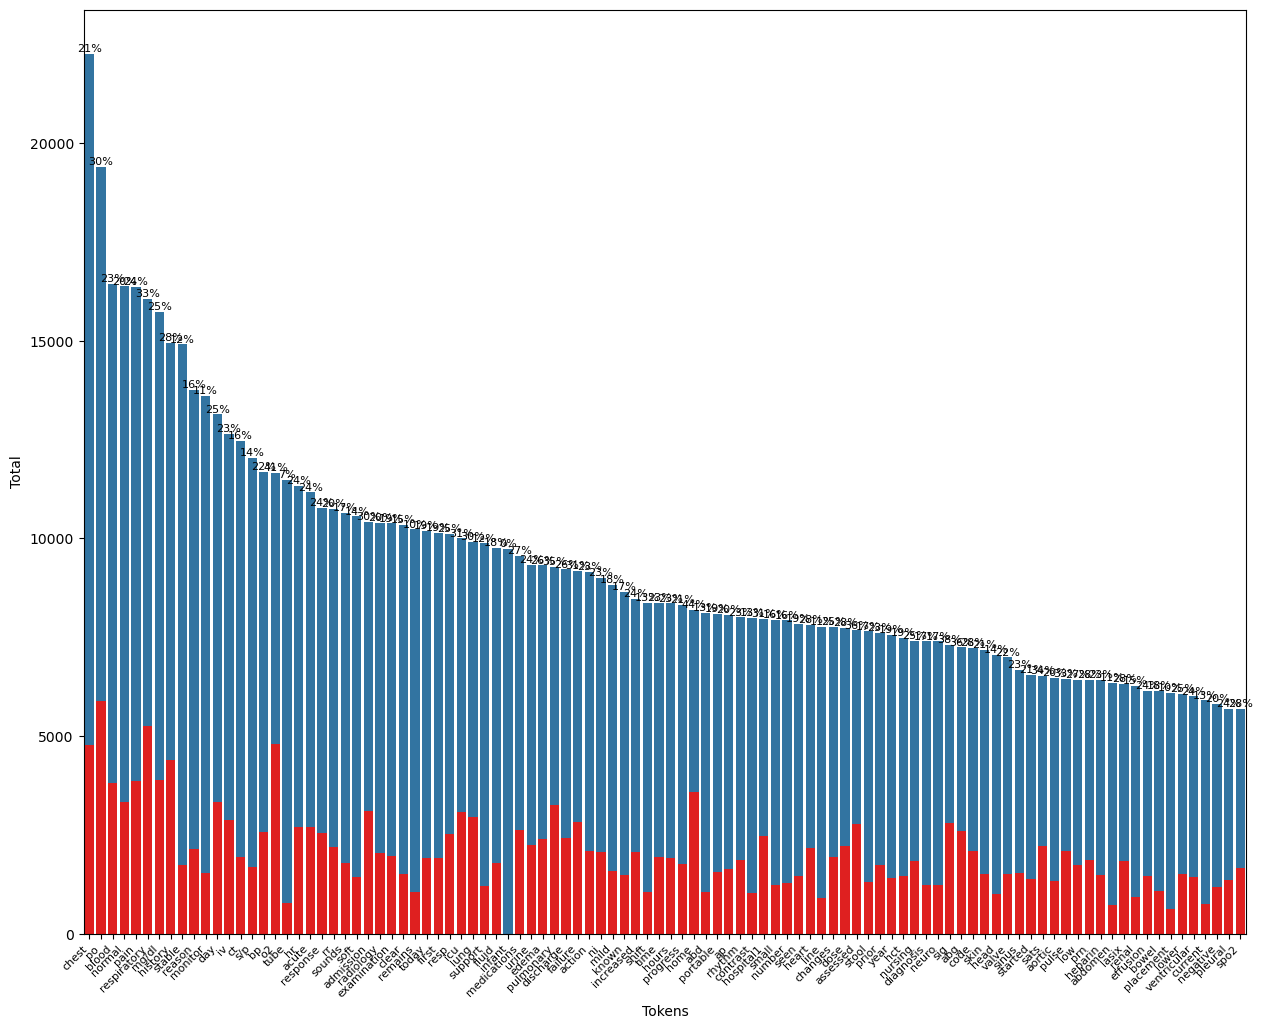

In [13]:
fig, subfigs = plt.subplots(figsize=(15, 12))

subset = count_data.head(100)

sns.barplot(data=subset, x='Tokens', y='Total', ax=subfigs)
sns.barplot(data=subset, x='Tokens', y='ARF', color='red', ax=subfigs)

total_ = subset['Total'].to_list()
percentage_ = subset['Percentage_ARF'].to_list()
for i, val in enumerate(percentage_):
    subfigs.text(i, total_[i], f'{int(val*100)}%', ha='center', va='bottom', fontsize=8)

subfigs.set_xticks(subfigs.get_xticks())
subfigs.set_xticklabels(labels=subset.Tokens, rotation=45, fontsize=8, ha='right');

# BERT Embeddings

In [14]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
max_length = 512

#model_name = 'medicalai/ClinicalBERT'
#tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = AutoModel.from_pretrained(model_name)

# Get GPU device
try:
    device = torch_directml.device()
    model.to(device)
except:
    print('Putting model on dml failed. Try putting on cpu instead')

In [15]:
tqdm.pandas()
df['BERT_EMBEDDINGS'] = list(df['PROCESSED_TEXT'].progress_apply((lambda x: get_bert_embedding(x, tokenizer, model, device, max_length))))
df.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1026/1026 [02:03<00:00,  8.29it/s]


,HADM_ID,TEXT,LABEL,PROCESSED_TEXT,BERT_EMBEDDINGS
81,100124,----category:discharge summary----\n\n--new:re...,ARF,discharge summary admission discharge year fem...,"[-0.36181381344795227, 0.2955072522163391, 0.3..."
139,100220,----category:discharge summary----\n\n--new:re...,ARF,discharge summary admission discharge history ...,"[-0.3038124740123749, 0.28583618998527527, 0.5..."
334,100557,----category:discharge summary----\n\n--new:re...,ARF,discharge summary admission discharge medicine...,"[-0.2952330410480499, 0.21240505576133728, 0.4..."
395,100660,----category:discharge summary----\n\n--new:re...,ARF,discharge summary admission discharge birth se...,"[-0.3522281348705292, 0.194341778755188, 0.492..."
567,100933,----category:discharge summary----\n\n--new:re...,ARF,discharge summary admission discharge hospital...,"[-0.48026156425476074, 0.24235758185386658, 0...."


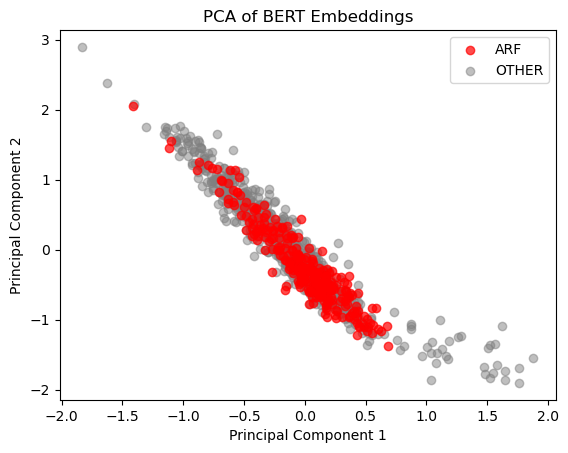

In [16]:
plot_pca(df.BERT_EMBEDDINGS.to_list(), df.LABEL.to_list(), title='PCA of BERT Embeddings', remove={'col': 'PC1', 'val': 2})

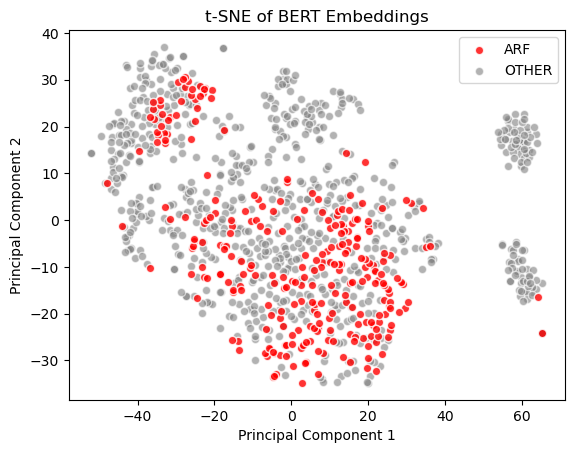

In [17]:
plot_tsne(df.BERT_EMBEDDINGS.to_list(), df.LABEL.to_list(), title='t-SNE of BERT Embeddings', #remove={'col': 'TSNE1', 'val': 2000},
         perplexity=20,
         n_iter=1000,
         lr=100)

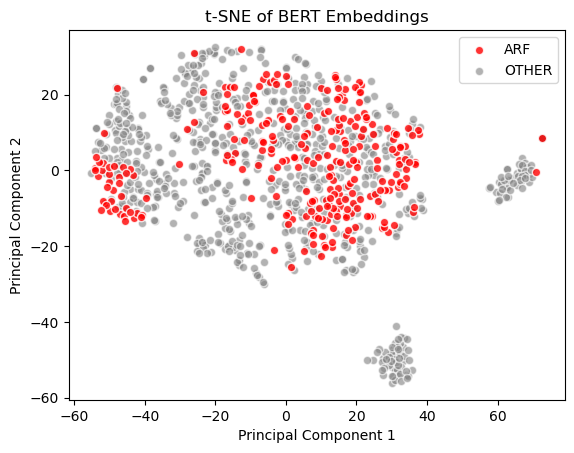

In [18]:
# Number of principal components (you can adjust this)
n_components = 50

# Perform PCA
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(df.BERT_EMBEDDINGS.to_list())


plot_tsne(principal_components, df.LABEL.to_list(), title='t-SNE of BERT Embeddings', #remove={'col': 'TSNE1', 'val': 2000},
         perplexity=20,
         n_iter=1000,
         lr=100)

# TF-IDF

In [20]:
corpus = df.PROCESSED_TEXT.to_list()

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

feature_names = vectorizer.get_feature_names_out()

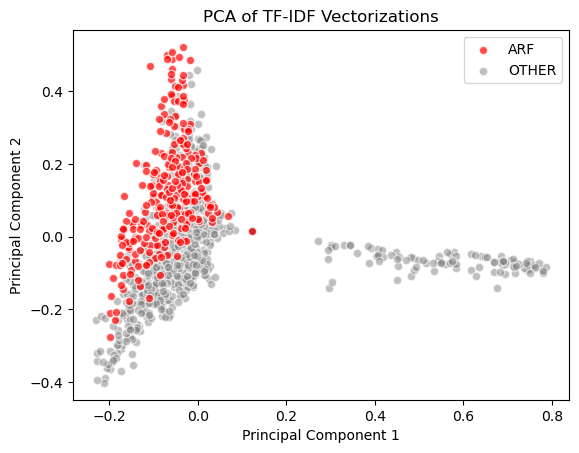

In [51]:
plot_pca(tfidf_matrix.toarray(), df.LABEL.to_list(), title='PCA of TF-IDF Vectorizations', remove={'col': 'PC1', 'val': 2})

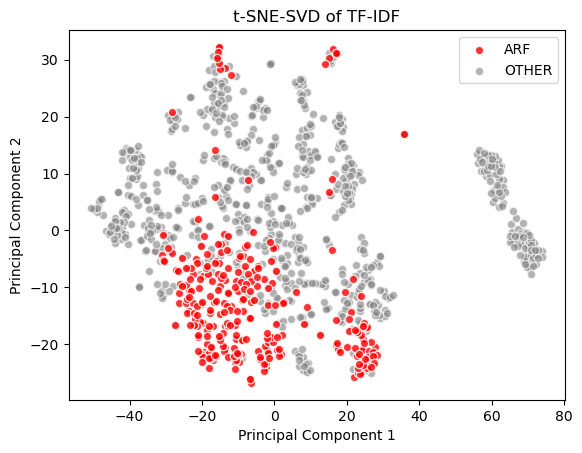

In [22]:
svd = TruncatedSVD(n_components=50)
tfidf_svd = svd.fit_transform(tfidf_matrix)

plot_tsne(tfidf_svd, df.LABEL.to_list(), title='t-SNE-SVD of TF-IDF', #remove={'col': 'TSNE1', 'val': 2000},
         perplexity=30,
         n_iter=1000,
         lr='auto')

/home/kolton/miniconda3/envs/pydml/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/kolton/miniconda3/envs/pydml/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/kolton/miniconda3/envs/pydml/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/kolton/miniconda3/envs/pydml/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill

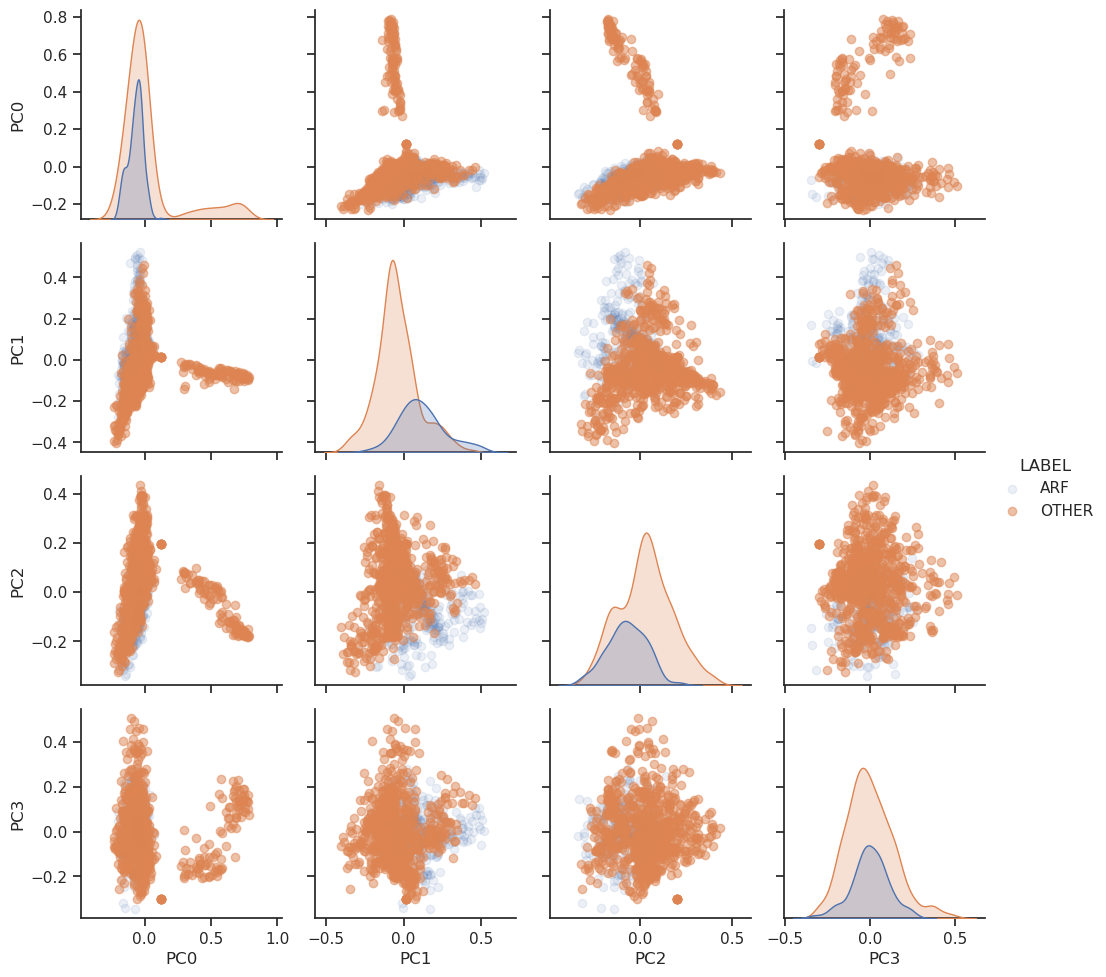

In [79]:
n_components = 4

pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

columns_pca = [f'PC{comp}' for comp in range(n_components)]
df_pca = pd.DataFrame(pca_result, columns=columns_pca)
df_pca['LABEL'] = df.LABEL.to_list()
#df_pca.sort_values(by='LABEL', ascending=False)

df_pca = df_pca.sample(frac=1)
# Create a scatterplot matrix using Seaborn
sns.set(style="ticks")
g = sns.PairGrid(df_pca, hue='LABEL', hue_kws={'alpha': [0.1, 0.5]})
g = g.map_diag(sns.kdeplot, shade=True)
g = g.map_lower(plt.scatter)
g = g.map_upper(plt.scatter)
g = g.add_legend()

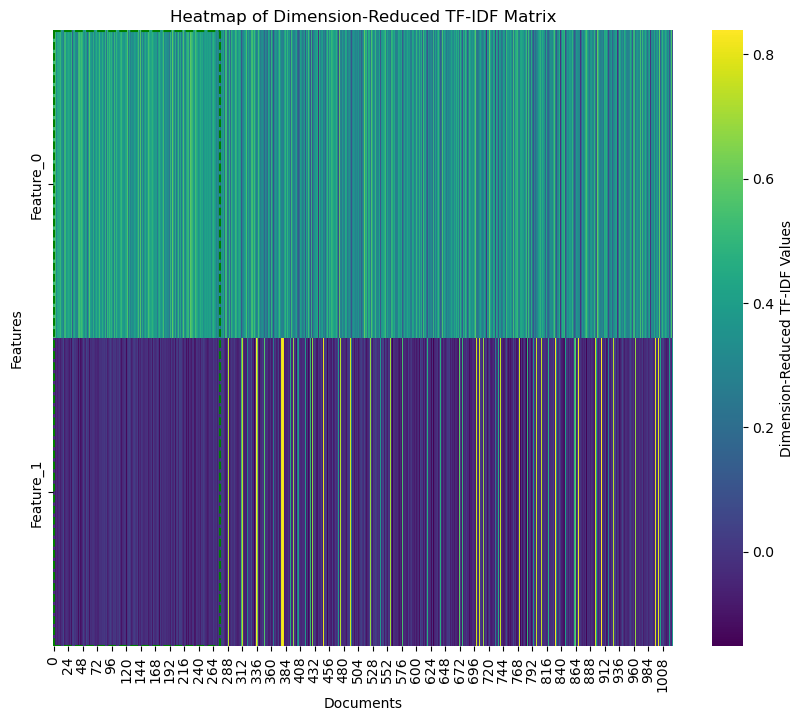

In [49]:
n_components = 2
svd = TruncatedSVD(n_components=n_components)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

# Create a DataFrame with the reduced TF-IDF matrix
df_tfidf_reduced = pd.DataFrame(tfidf_matrix_reduced, columns=[f'Feature_{i}' for i in range(n_components)])
#df_tfidf_reduced['LABEL'] = df['LABEL'].to_list()
#df_tfidf_reduced.sort_values(by='LABEL')

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_tfidf_reduced.transpose(), cmap='viridis', cbar_kws={'label': 'Dimension-Reduced TF-IDF Values'})
plt.xlabel('Documents')
plt.ylabel('Features')
plt.title('Heatmap of Dimension-Reduced TF-IDF Matrix')


# Highlight cells corresponding to specific labels
#plt.annotate('ARF', xy=(276, 0), ha='center', va='center', color='red', fontsize=8, rotation=45)
plt.axvline(x=276, color='g', linestyle='--')
plt.axvline(x=1, color='g', linestyle='--')
plt.axhline(y=1.999, color='g', xmin=0, xmax=276/len(df_tfidf_reduced), linestyle='--')
plt.axhline(y=.001, color='g', xmin=0, xmax=276/len(df_tfidf_reduced), linestyle='--')


Text(0.5, 1.0, 'Heatmap of Averaged Dimension-Reduced TF-IDF Matrix')

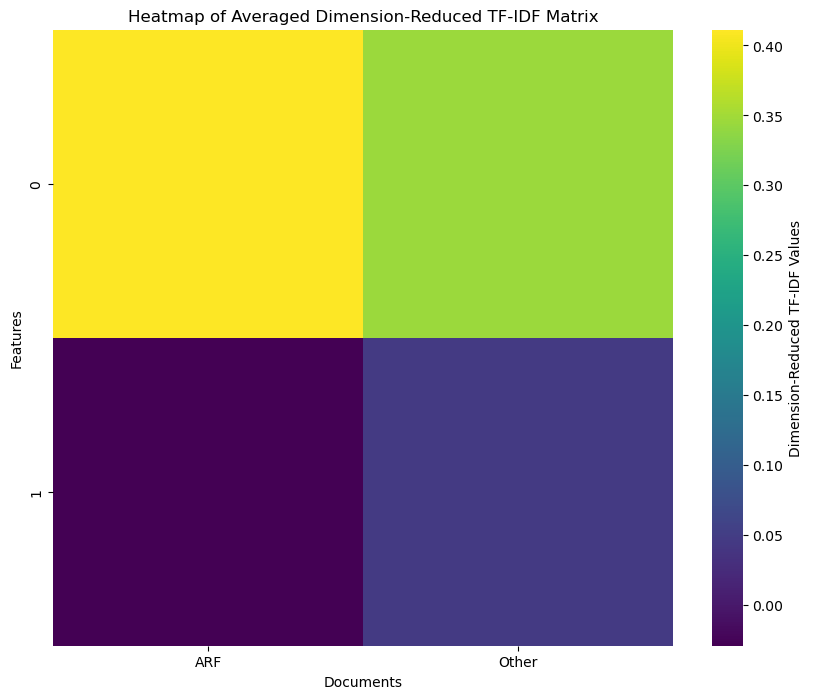

In [37]:
feat1_arf = df_tfidf_reduced.iloc[:276]['Feature_0'].mean()
feat2_arf = df_tfidf_reduced.iloc[:276]['Feature_1'].mean()

feat1_other = df_tfidf_reduced.iloc[276:]['Feature_0'].mean()
feat2_other = df_tfidf_reduced.iloc[276:]['Feature_1'].mean()

averaged_tfidf_reduced = pd.DataFrame({'ARF': [feat1_arf, feat2_arf], 'Other': [feat1_other, feat2_other]})

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(averaged_tfidf_reduced, cmap='viridis', cbar_kws={'label': 'Dimension-Reduced TF-IDF Values'})
plt.xlabel('Documents')
plt.ylabel('Features')
plt.title('Heatmap of Averaged Dimension-Reduced TF-IDF Matrix')

In [25]:
df_tfidf_reduced['Label'] = labels

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Feature_0', y='Feature_1', hue='Label', data=df_tfidf_reduced, palette='viridis')

# Annotate the points with document indices
#for i, label in enumerate(labels):
#    plt.annotate(i, (df_tfidf_reduced['Feature_0'][i], df_tfidf_reduced['Feature_1'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Set labels and title
plt.xlabel('Feature 0 (Dimension-Reduced TF-IDF)')
plt.ylabel('Feature 1 (Dimension-Reduced TF-IDF)')
plt.title('Scatter Plot of Dimension-Reduced TF-IDF Values with Annotations')

NameError: name 'labels' is not defined